# Convertendo imagens Sentinel-3 NetCDF em GeoTIFF

Autoria: Sabrina Correa (paeslemesa@gmail.com) <br>
Criação: 04/04/2024 <br>
Modificação: 08/04/2024 <br>

__Observações__ O raster resultante ainda precisa ser ajustado em software GIS: correções geométricas precisam ser feitas.


Referências:
* https://github.com/corteva/rioxarray/discussions/329
* https://browser.dataspace.copernicus.eu/
* https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-olci/naming-convention
* https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-olci/resolutions/radiometric


# 1. Baixando os dados

Para tratar esses dados no modo raíz, precisamos primeiro seguir esse passo a passo:

* Você deve acessar a página: https://browser.dataspace.copernicus.eu/
* Escolher o tipo de dado que você prefere trabalhar. Para ter mais informações, acesse: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-olci/naming-convention
* Neste tutorial, vamso trabalhar apenas com dados EFR: radiância do topo da atmosfera em resolução máxima

No site da ESA (Agência Espacial Europeia), você pode selecionar sua área de estudo, datas e tudo mais. É necessário fazer cadastro para baixar os dados!

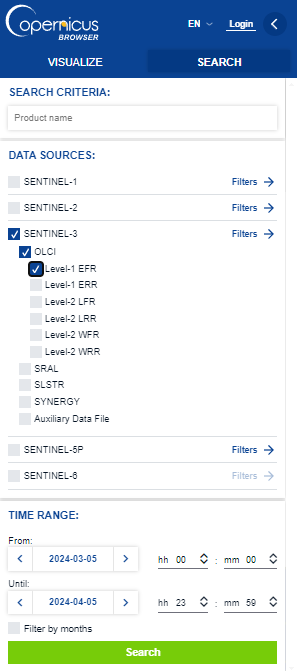

# 2. Importanto Bibliotecas e Determinando Dados de Entrada e saída

In [1]:
from pathlib import Path
import os

import numpy as np

import rasterio as rio
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint

import xarray as xr
import rioxarray as rxr

Aqui vamos selecionar a pasta descompactada que foi baixada do site da ESA. Em <code>WKDIR</code> (diretório de trabalho), vamos copiar e colar o caminho.

In [2]:
wkdir = Path(r".\Sentinel3\S3B_OL_1_EFR____20230819T132952_20230819T133252_20230819T151234_0179_083_081_3060_PS2_O_NR_003.SEN3") # pasta onde estão as imagens

os.chdir(wkdir) # mudando o caminho para a pasta onde estão as imagens


Aqui já vamos selecionar algumas bandas para trabalhar. Lembrando que esse satélite trabalho com dados TOA (topo da atmosfera), então eles vão precisar de correção atmosférica.

Mas as bandas que vamos trabalhar são as mais similares ao Sentinel-2. <br>
Para mais informações sobre as bandas, acessar: https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-olci/resolutions/radiometric

In [3]:
# Bandas que serão utilizadas
bandas = ['Oa04_radiance', # Banda Azul
          'Oa06_radiance', # Banda Verde
          'Oa08_radiance', # Banda Vermelha
          'Oa17_radiance'] # Banda NIR

# 3. Abrir dados de coordenadas

Ao baixar o arquivo ZIP do Sentinel-3 OLCI no EFR, os arquivos serão os mostrados na imagem abaixo. Cada banda, assim como as informações de coordenada e tempo são armazenadas separadamente. Então devemos abrir também separadamente.


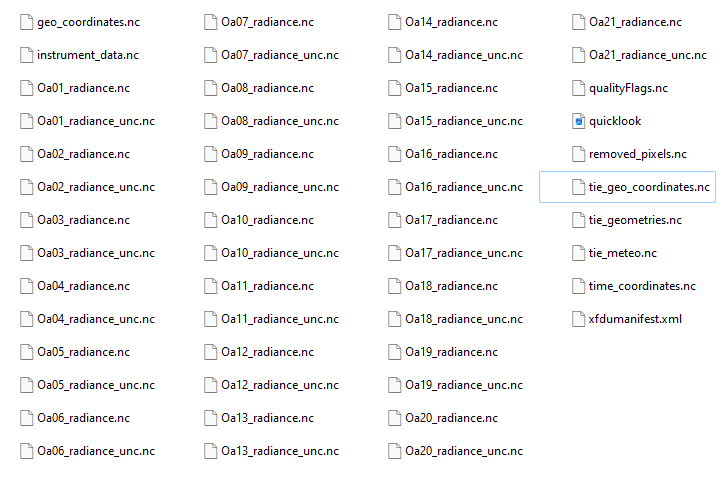

<br>
<br>
Em primrio momento, vamso abrir só as informações de coordenadas, no arquivo <code>geo_coordinates.nc</code>. O que vamos fazer aqui é pegar os dados de coordenadas e usar eles como pontos de controle (GCP) para criar uma transformação Afim para podermos salvar a imagem com o <code>rasterio</code>.

In [4]:
# Abrindo o arquivo de coordenadas com RioXarray
geo = rxr.open_rasterio("geo_coordinates.nc")

c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(r

Criando uma lista com GCPs (_ground control points_, ou pontos de controle) para encontrarmos a transformação Afim da imagem.

Os GCPs serão uma lista, onde cada GCP será uma lista com a posição de <code>(linha, coluna, coordenadaX, coordenadaY, id)</code>, fazendo aligação entre o sistema fotogramétrico (linha/coluna) e o sistema absoluto (lat/lon, por exemplo). Outro ponto que devemos observar, é que os dados de lat/lon.

Outro ponto é que, para reduzir o tempo de computação, vamos selecionar pixels de 50 em 50 pontos, mas esse valor pode ser alterado.

In [5]:
linhas = geo.y.size # numero de linhas
colunas = geo.x.size # numero de colunas

# Fator de escala para latitude e longitude, costuma ser 1e-6
sc_geo = geo.data_vars['longitude'].attrs['scale_factor']

passo = 50 # passo para amostragem de pontos de controle

gcps = [] # lista de pontos de controle

id = 0
for i in range(0,colunas, passo):
    for j in range(0,linhas, passo):
        gcps.append(GroundControlPoint( #culuna-linha
                                            row=geo.y.data[j], # linha
                                            col=geo.x.data[i], # coluna
                                            y=geo.latitude.data[:,j,i][0]*sc_geo, # latitude
                                            x=geo.longitude.data[:,j,i][0]*sc_geo # longitude
                                            ))
        id += 1

print(f"Total de pontos de controle: {id}")

Total de pontos de controle: 8036


Agora, vamos definir o sistema de referência coordenado (CRS) da imagem. Os dados do Sentinel-3 vem no <code>EPSG:4326</code> (https://epsg.io/4326).

E daí vamos criar a transformação Afim, que é composta em geral por 6 parâmetros.

In [6]:
# Definindo o EPSG 4326: sendo sistema não projetado WGS 84
crs = rio.crs.CRS.from_epsg(4326)
transform = from_gcps(gcps) # transformação a partir dos pontos de controle

# A transformação é uma matriz 3x3, onde:
# transform[0] = escala em X
# transform[1] = rotação em X
# transform[2] = translação em X - longitude do ponto (0,0)
# transform[3] = rotação em Y
# transform[4] = escala em Y
# transform[5] = translação em Y - latitude do ponto (0,0)
transform

Affine(0.0023834878663851994, 0.0005954513763300896, -63.67503729944852,
       -0.0005467497058349229, 0.002589724937280375, -10.699595868446117)

# 4. Abrir dados das bandas

Aqui vamos criar um Numpy Array de tamanho <code>(n_bandas, n_linhas, n_colunas)</code>. Além disso, vamos trocar os valores nulos do S3 para <code>np.nan</code> e multiplicar cada dado por seu fator de escala respectivo.

In [7]:
print(bandas)

['Oa04_radiance', 'Oa06_radiance', 'Oa08_radiance', 'Oa17_radiance']


Agora, vamos abrir todas as bandas e concatenar no array.

In [8]:
for i in range(len(bandas)):
    ds = rxr.open_rasterio(bandas[i] + ".nc") # abrindo a banda
    nan_value = ds.attrs['_FillValue'] # valor de preenchimento
    sc = ds.attrs['scale_factor'] # fator de escala de cada banda

    temp = ds.values # valores da banda
    temp = np.where(temp == nan_value, np.nan, temp) # substituindo valores de preenchimento por NaN
    temp = temp * sc # aplicando o fator de escala
    print(sc)
    if i ==0:
        img = temp # criando a imagem
    else:
        img = np.concatenate((img, temp), axis=0) # concatenando as bandas

c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


0.011396283283829689


c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


0.010038239881396294


c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


0.008974685333669186


c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


0.006055756937712431


# 5. Salvando o arquivo

Para salvar o arquivo, é necessário criar um arquivo meta (ou profile) para determinarmos os parâmetros da imagem.

In [9]:
meta = { 'count': img.shape[0], # número de bandas da imagem
         'width' : img.shape[2], # número de colunas
         'height' : img.shape[1], # número de linhas
         'crs'    : crs, # sistema de coordenadas da imagem
         'transform' : transform, # transformação Afim da imagem
         'dtype' : img.dtype, # tipo de dado (float32, no meu caso)
         'nodata' : np.nan, # valor de preenchimento
         'driver' : 'GTiff', # driver do rasterio
         'compress' : 'lzw'} # compressão LZW
meta

{'count': 4,
 'width': 4865,
 'height': 4091,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0023834878663851994, 0.0005954513763300896, -63.67503729944852,
        -0.0005467497058349229, 0.002589724937280375, -10.699595868446117),
 'dtype': dtype('float64'),
 'nodata': nan,
 'driver': 'GTiff',
 'compress': 'lzw'}

In [10]:
with rio.open("Sentinell-3_saida.tif", 'w', **meta) as dst:
    dst.write(img)